# 3. Data analysis

In [1]:
from IPython.display import display, HTML
import matplotlib as mpl
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import statsmodels.tsa.stattools as tsa
import pandas as pd
import seaborn as sns
from scipy import stats
sns.set(style='ticks', rc={'axes.grid':True,
                           'xtick.labelsize': 'medium',
                           'ytick.labelsize': 'medium',
#                            'font.size': 15,
                          })
# mpl.rcParams.update({'font.size': 15})
# plt.rc('ytick', labelsize='small') 


# assume the notebook is in the right place and set up the plot path
analysis_dir = _dh[0]
assert analysis_dir.endswith(os.path.join('em-2020','analysis'))
plot_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'tex', 'plots'))
data_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'data'))

In [2]:
SAVE = True

def save_table(table, file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        with open(path, 'w') as fd:
            fd.write(table.to_latex(**kwargs))
        
def save_fig(file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        plt.savefig(path, metadata={'CreationDate': None})

def load_data(country, version='current'):
    data_file = os.path.join(data_dir, 'WB_{}_{}.csv'.format(country, version))
    data_raw = pd.read_csv(data_file, index_col='year')
    cols = ['ISG', 'TO', 'TI', 'P_GDP', 'P_GDPb', 'EI', 'EIb']
    if 'EIc' in data_raw:
        cols.append('EIc')

    return data_raw[cols]
    
def summary_stats(data, country, version):
    stats = ref_data.describe().T[['min', 'max', 'mean', 'std', 'count']]
    stats['count'] = stats['count'].astype(int)
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(stats)
        print(stats.to_latex())
#         save_table(stats, '_'.join((country, version, 'descriptive_statistics.tex')))

In [3]:
def plot_corr(data, figsize=None, **kwargs):
    corr = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[0])
    significance = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[1])
    corr_text = corr.applymap('{:.3f}'.format) + np.where(significance < .01, '*', '')

    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    if figsize is None:
        figsize=np.array([1, 0.75]) * corr.shape[0] + np.array([kwargs.get('cbar', True) * 1.5, 0])
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, s=50, l=85, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=corr_text, fmt='', mask=mask, cmap=cmap, 
                square=False, linewidths=.25, vmin=-1, vmax=1, **kwargs)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'verticalalignment': 'center'})

In [4]:
countries = ['BGD', 'IND', 'GBR']
raw_data = pd.concat([load_data(c, 'current') for c in countries],
                     keys=countries, names=['country', 'year'])
cmp_data = raw_data.loc[pd.IndexSlice[:, 1986:], :].copy()

In [5]:
cmp_data.groupby(level='country').describe().T.xs('mean', level=1)

country,BGD,GBR,IND
ISG,23.470421,21.592732,28.070682
TO,31.156640,53.167799,32.523293
TI,248.181818,26839.393939,20974.454545
P_GDP,608.823333,31897.401171,813.043737
P_GDPb,2005.334110,30785.658267,3389.981706
EI,0.351282,0.137837,0.803261
EIb,0.103602,0.133634,0.184327
EIc,NaN,0.096291,0.142844


In [6]:
log_cols = ['EI', 'EIb', 'EIc', 'P_GDP', 'P_GDPb', 'TI']
cmp_data.loc[:, log_cols] = np.log(cmp_data.loc[:, log_cols])


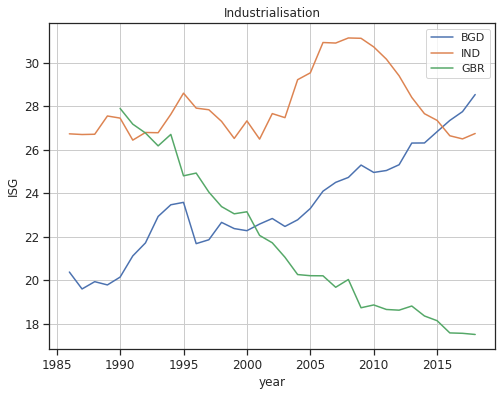

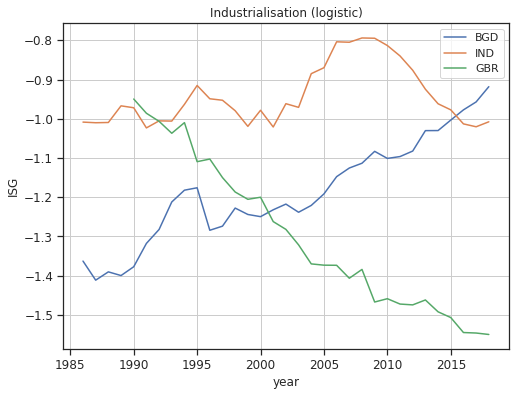

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['ISG'].unstack(level=0).plot(ax=ax)
plt.title('Industrialisation')
plt.ylabel('ISG')
plt.legend(loc='best')
save_fig('ISG_timeseries.pdf')

f, ax = plt.subplots(figsize=(8, 6))
x = cmp_data['ISG'].unstack(level=0)
plt.title('Industrialisation (logistic)')
np.log(x / (100-x)).plot(ax=ax, grid=True)
plt.ylabel('ISG')
plt.legend(loc='best')


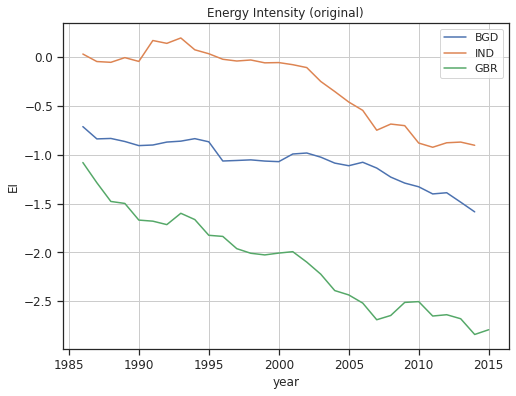

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['EI'].unstack(level=0).plot(ax=ax)
plt.title('Energy Intensity (original)')
plt.ylabel('EI')
plt.legend(loc='best')
save_fig('EI_timeseries.pdf')

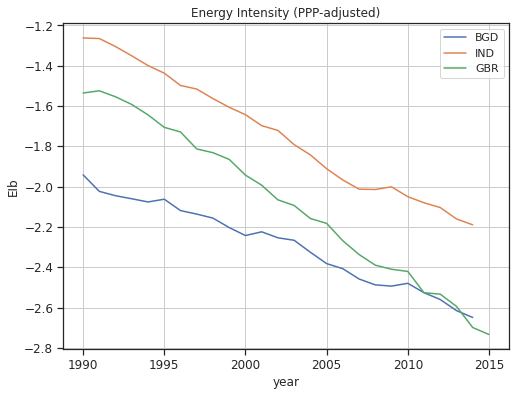

In [9]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['EIb'].unstack(level=0).plot(ax=ax)
plt.title('Energy Intensity (PPP-adjusted)')
plt.ylabel('EIb')
plt.legend(loc='best')
save_fig('EIb_timeseries.pdf')

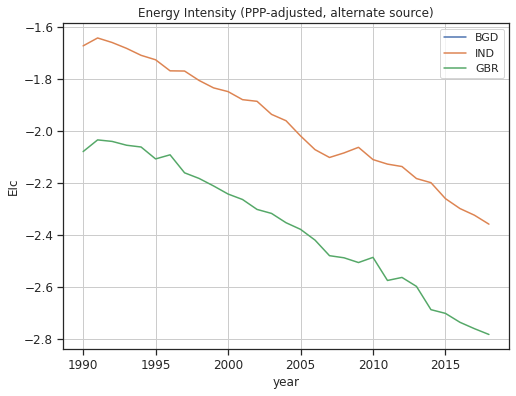

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['EIc'].unstack(level=0).plot(ax=ax)
plt.title('Energy Intensity (PPP-adjusted, alternate source)')
plt.ylabel('EIc')
plt.legend(loc='best')
save_fig('EIc_timeseries.pdf')

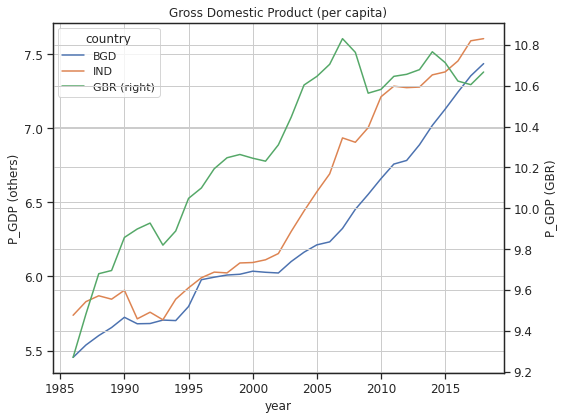

In [11]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['P_GDP'].unstack(level=0).plot(ax=ax, secondary_y='GBR', grid=True)
plt.title('Gross Domestic Product (per capita)')
plt.ylabel('P_GDP (GBR)')
ax.set_ylabel('P_GDP (others)')
plt.tight_layout()
save_fig('P_GDP_timeseries.pdf')

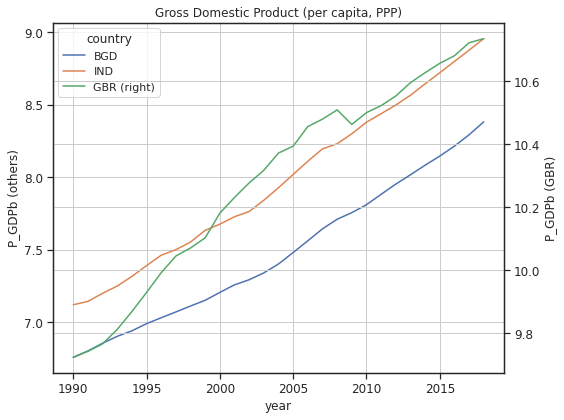

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['P_GDPb'].unstack(level=0).plot(ax=ax, secondary_y='GBR', grid=True)
plt.title('Gross Domestic Product (per capita, PPP)')
plt.ylabel('P_GDPb (GBR)')
ax.set_ylabel('P_GDPb (others)')
plt.tight_layout()
save_fig('P_GDPb_timeseries.pdf')

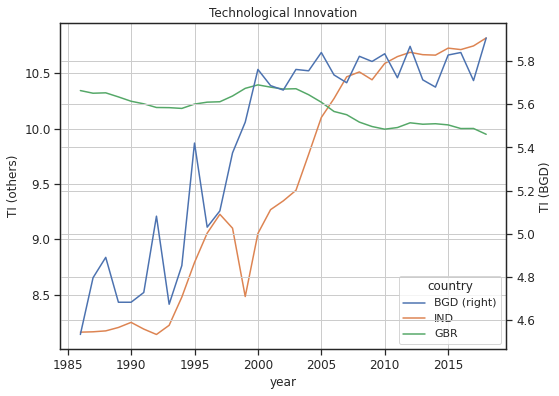

In [13]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['TI'].unstack(level=0).plot(ax=ax, secondary_y='BGD', grid=True)
plt.title('Technological Innovation')
plt.ylabel('TI (BGD)')
ax.set_ylabel('TI (others)')
save_fig('TI_timeseries.pdf')

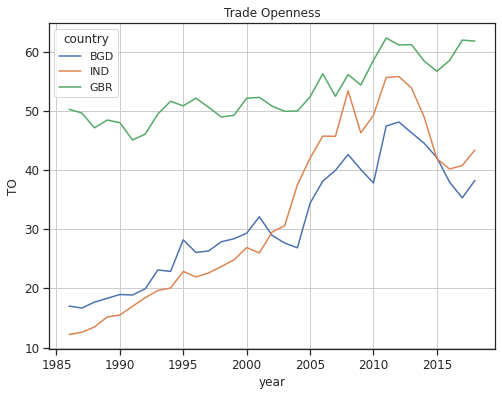

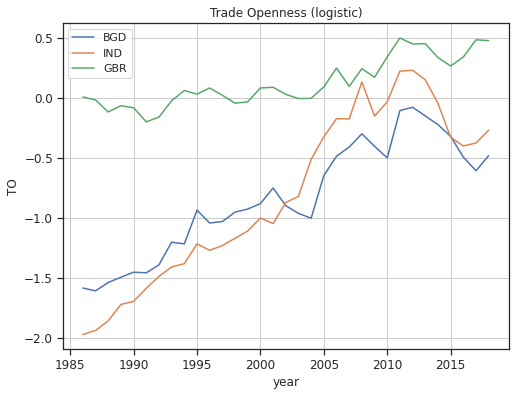

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['TO'].unstack(level=0).plot(ax=ax, grid=True)
plt.title('Trade Openness')
plt.ylabel('TO')
save_fig('TO_timeseries.pdf')

f, ax = plt.subplots(figsize=(8, 6))
x = cmp_data['TO'].unstack(level=0)
plt.title('Trade Openness (logistic)')
np.log(x / (100-x)).plot(ax=ax, grid=True)
plt.ylabel('TO')
plt.legend(loc='best')

In [15]:
log_data = raw_data.copy()
log_data[log_cols] = np.log(log_data[log_cols])
logdiff_data = log_data.groupby(level='country').diff().loc[pd.IndexSlice[:, 1986:], :]
log_data = log_data.loc[pd.IndexSlice[:, 1986:], :]
logdiff_data

ISG        TO        TI     P_GDP    P_GDPb        EI  \
country year                                                               
BGD     1986  0.057351 -1.203442 -0.380055 -0.049250       NaN  0.091232   
        1987 -0.778197 -0.330945  0.263191  0.083375       NaN -0.125358   
        1988  0.335391  0.990267  0.094559  0.063776       NaN  0.004645   
        1989 -0.149502  0.647110 -0.208218  0.054385       NaN -0.031072   
        1990  0.358919  0.641328  0.000000  0.069068       NaN -0.042025   
...                ...       ...       ...       ...       ...       ...   
GBR     2015 -0.217864 -1.715294 -0.010427 -0.053085  0.029867  0.048442   
        2016 -0.560478  1.815189 -0.033084 -0.090530  0.024026       NaN   
        2017 -0.018522  3.446853  0.000589 -0.017505  0.041287       NaN   
        2018 -0.053352 -0.168631 -0.052601  0.062020  0.013017       NaN   
        2019       NaN       NaN       NaN       NaN       NaN       NaN   

                   EIb       EIc  
country year                      
BGD     1986       NaN       NaN  
        1987       NaN       NaN  
        1988       NaN       NaN  
        1989       NaN       NaN  
        1990       NaN       NaN  
...                ...       ...  
GBR     2015 -0.034511 -0.014315  
        2016       NaN -0.034376  
        2017       NaN -0.024615  
        2018       NaN -0.022366  
        2019       NaN       NaN  

[102 rows x 8 columns]

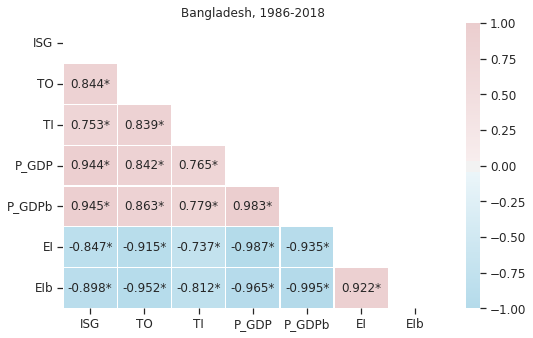

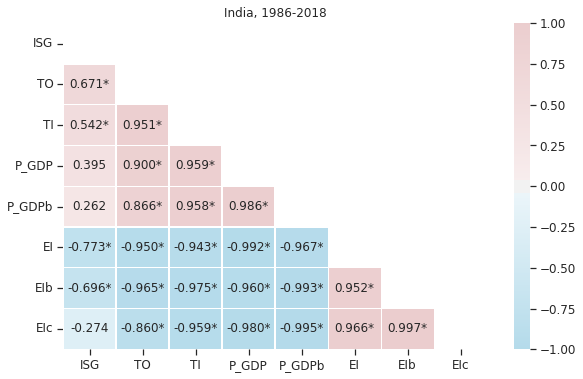

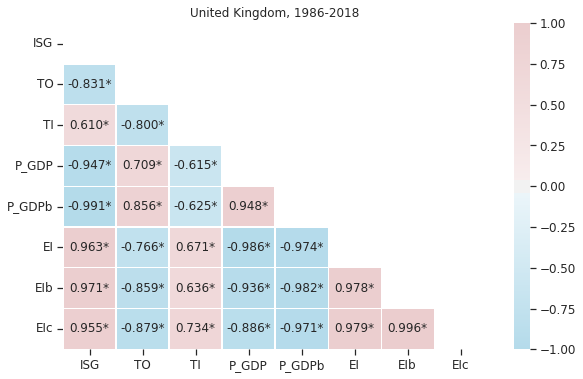

In [16]:
plot_corr(log_data.xs('BGD', level='country').drop(columns='EIc'))
plt.title('Bangladesh, 1986-2018')
save_fig('_'.join(('BGD', 'current', 'correlations.pdf')))

plot_corr(log_data.xs('IND', level='country'))
plt.title('India, 1986-2018')
save_fig('_'.join(('IND', 'current', 'correlations.pdf')))

plot_corr(log_data.xs('GBR', level='country'))
plt.title('United Kingdom, 1986-2018')
save_fig('_'.join(('GBR', 'current', 'correlations.pdf')))

In [17]:
def adf(x, index=1):
    try:
        return tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', maxlag=3)[index]
    except:
        return np.nan

by_country_var = log_data.stack().groupby(level=[0,2])
adf_stat = by_country_var.apply(adf, 0).unstack()
adf_pval = by_country_var.apply(adf, 1).unstack()
f2n = lambda x: '{:.2f}'.format(x) if np.isfinite(x) else ''
f3n = lambda x: '*' if (x < 0.001) else '{:.3f}'.format(x) if np.isfinite(x) else ''
display(adf_stat.round(2))
display(adf_pval.round(3))
print(adf_stat.reset_index().to_latex(float_format=f2n, index=False))
print(adf_pval.reset_index().to_latex(float_format=f3n, index=False))

,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
BGD,-1.06,-2.48,NaN,-2.05,-0.74,-0.84,-0.67,-1.75
GBR,-3.28,-4.92,-5.19,-0.70,-2.04,-0.71,-1.96,-3.26
IND,-1.74,-1.50,-3.18,-2.54,-1.81,-1.56,-2.14,-0.95


,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
BGD,0.935,0.336,NaN,0.575,0.970,0.962,0.975,0.730
GBR,0.069,0.000,0.000,0.973,0.578,0.972,0.621,0.073
IND,0.735,0.831,0.089,0.308,0.702,0.806,0.526,0.950


\begin{tabular}{lrrrrrrrr}
\toprule
country &    EI &   EIb &   EIc &   ISG &  P\_GDP &  P\_GDPb &    TI &    TO \\
\midrule
    BGD & -1.06 & -2.48 &       & -2.05 &  -0.74 &   -0.84 & -0.67 & -1.75 \\
    GBR & -3.28 & -4.92 & -5.19 & -0.70 &  -2.04 &   -0.71 & -1.96 & -3.26 \\
    IND & -1.74 & -1.50 & -3.18 & -2.54 &  -1.81 &   -1.56 & -2.14 & -0.95 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
country &    EI &   EIb &   EIc &   ISG &  P\_GDP &  P\_GDPb &    TI &    TO \\
\midrule
    BGD & 0.935 & 0.336 &       & 0.575 &  0.970 &   0.962 & 0.975 & 0.730 \\
    GBR & 0.069 &     * &     * & 0.973 &  0.578 &   0.972 & 0.621 & 0.073 \\
    IND & 0.735 & 0.831 & 0.089 & 0.308 &  0.702 &   0.806 & 0.526 & 0.950 \\
\bottomrule
\end{tabular}



In [18]:
x = cmp_data.xs('BGD', level='country')['TI']
display(tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=False))
r = tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=True)
r[-1].resols.params

(-2.7788569400786947,
 0.2048184188068774,
 0,
 32,
 {'1%': -4.27353517944336,
  '5%': -3.5578989233398435,
  '10%': -3.2123659912109375},
 -36.17400565101508)

array([-0.41408078,  2.03103741,  0.01526528])

In [19]:
by_country_var = logdiff_data.stack().groupby(level=[0,2])
adf_stat = by_country_var.apply(adf, 0).unstack()
adf_pval = by_country_var.apply(adf, 1).unstack()
display(adf_stat.round(2))
display(adf_pval.round(3))
print(adf_stat.reset_index().to_latex(float_format=f2n, index=False))
print(adf_pval.reset_index().to_latex(float_format=f3n, index=False))

,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
BGD,-3.98,-5.44,NaN,-4.86,-3.97,-3.83,-7.93,-5.15
GBR,-4.65,-4.94,-7.99,-9.73,-4.42,-4.95,-2.73,-6.11
IND,-5.15,-4.57,-5.44,-2.29,-5.36,-4.45,-4.96,-4.94


,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
BGD,0.009,0.000,NaN,0.000,0.010,0.015,0.000,0.0
GBR,0.001,0.000,0.0,0.000,0.002,0.000,0.222,0.0
IND,0.000,0.001,0.0,0.438,0.000,0.002,0.000,0.0


\begin{tabular}{lrrrrrrrr}
\toprule
country &    EI &   EIb &   EIc &   ISG &  P\_GDP &  P\_GDPb &    TI &    TO \\
\midrule
    BGD & -3.98 & -5.44 &       & -4.86 &  -3.97 &   -3.83 & -7.93 & -5.15 \\
    GBR & -4.65 & -4.94 & -7.99 & -9.73 &  -4.42 &   -4.95 & -2.73 & -6.11 \\
    IND & -5.15 & -4.57 & -5.44 & -2.29 &  -5.36 &   -4.45 & -4.96 & -4.94 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
country &    EI &   EIb &  EIc &   ISG &  P\_GDP &  P\_GDPb &    TI &  TO \\
\midrule
    BGD & 0.009 &     * &      &     * &  0.010 &   0.015 &     * &   * \\
    GBR &     * &     * &    * &     * &  0.002 &       * & 0.222 &   * \\
    IND &     * & 0.001 &    * & 0.438 &      * &   0.002 &     * &   * \\
\bottomrule
\end{tabular}



In [20]:
gbr_ei = np.log(raw_data.xs('GBR', level='country')[['EI']])
gbr_ei['dEI'] = gbr_ei['EI'].diff()
gbr_ei['ddEI'] = gbr_ei['dEI'].diff()
gbr_ei['dddEI'] = gbr_ei['ddEI'].diff()

gbr_ei.loc[1986:].apply(lambda x:
    tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=False)[1])

EI       0.041495
dEI      0.976150
ddEI     0.889246
dddEI    0.005267
dtype: float64

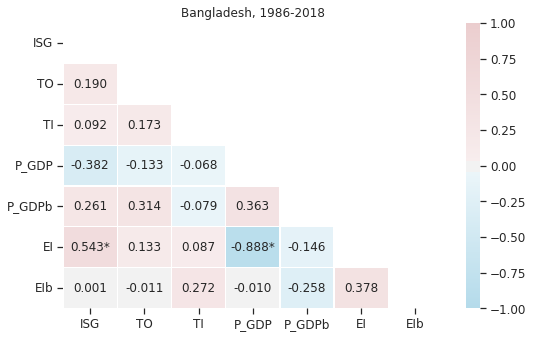

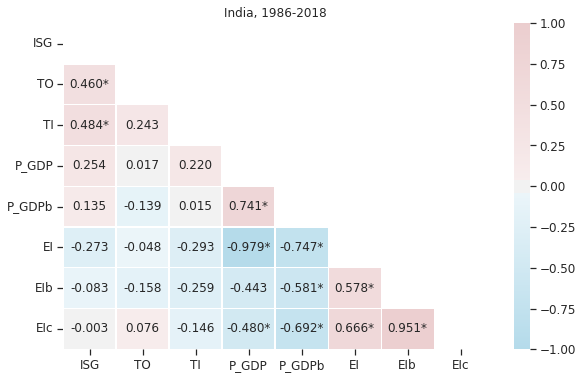

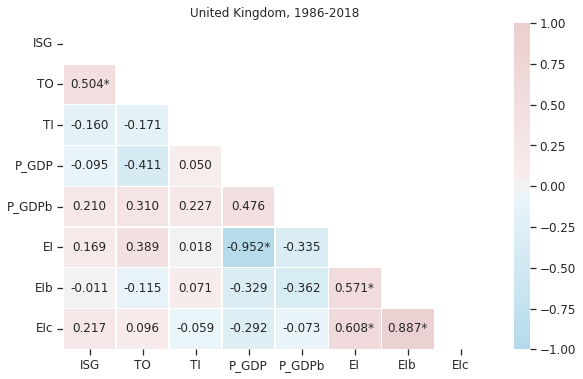

In [21]:
plot_corr(logdiff_data.xs('BGD', level='country').drop(columns='EIc'))
plt.title('Bangladesh, 1986-2018')
save_fig('_'.join(('BGD', 'current', 'diff_correlations.pdf')))

plot_corr(logdiff_data.xs('IND', level='country'))
plt.title('India, 1986-2018')
save_fig('_'.join(('IND', 'current', 'diff_correlations.pdf')))

plot_corr(logdiff_data.xs('GBR', level='country'))
plt.title('United Kingdom, 1986-2018')
save_fig('_'.join(('GBR', 'current', 'diff_correlations.pdf')))

In [22]:
def corr_annot(x, y, ax=None, **kwargs):
    if len(x) + len(y) < 4:
        return
    ax = ax or plt.gca()
    rho, p = stats.pearsonr(x,y)
    signif = '*' if p < .01 else ''
    ax.annotate(r'{:.3f}'.format(rho) + signif, xy=(.1, .9), xycoords=ax.transAxes)

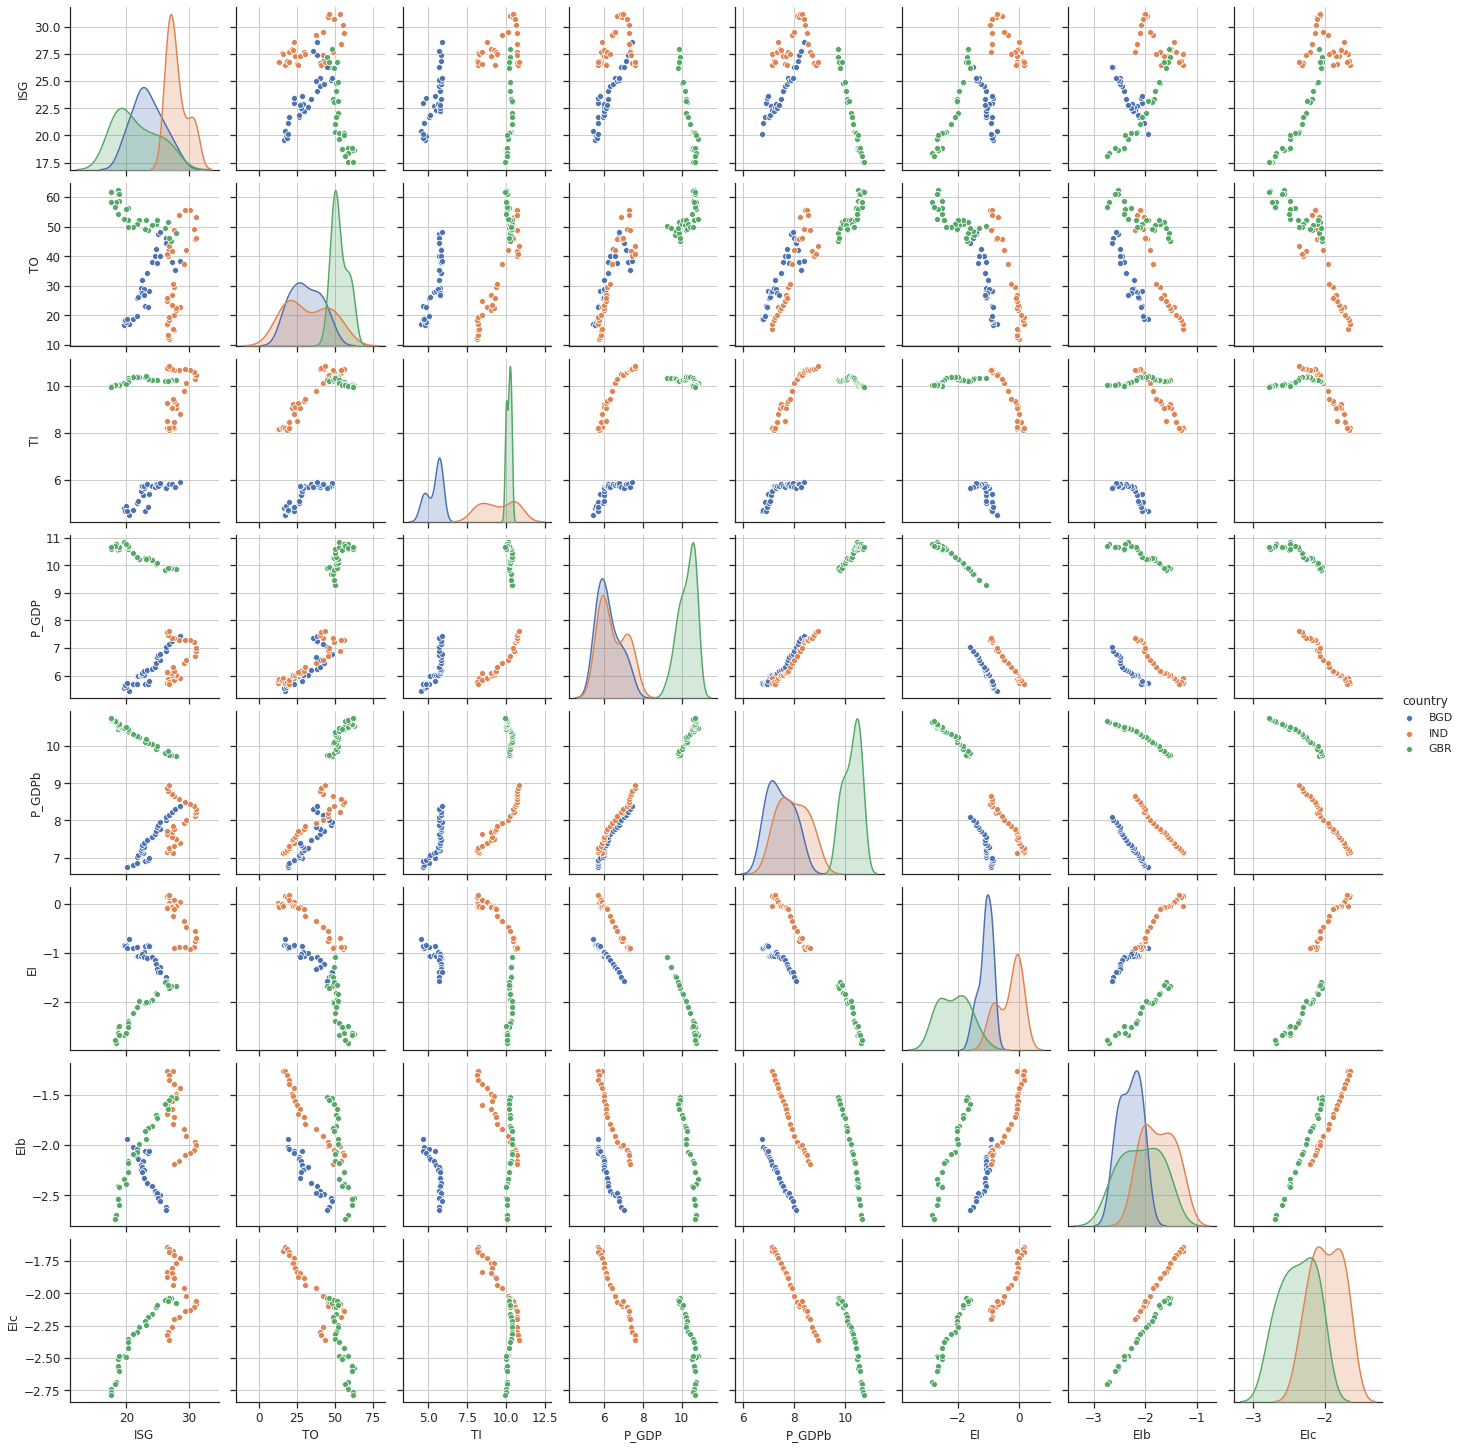

In [23]:
to_compare = log_data.loc[pd.IndexSlice[['GBR','IND','BGD'], :], :].reset_index().drop(columns='year')
g = sns.pairplot(to_compare, hue='country')
g.fig.subplots_adjust(left=0.075)
save_fig('log_pairplot.pdf')

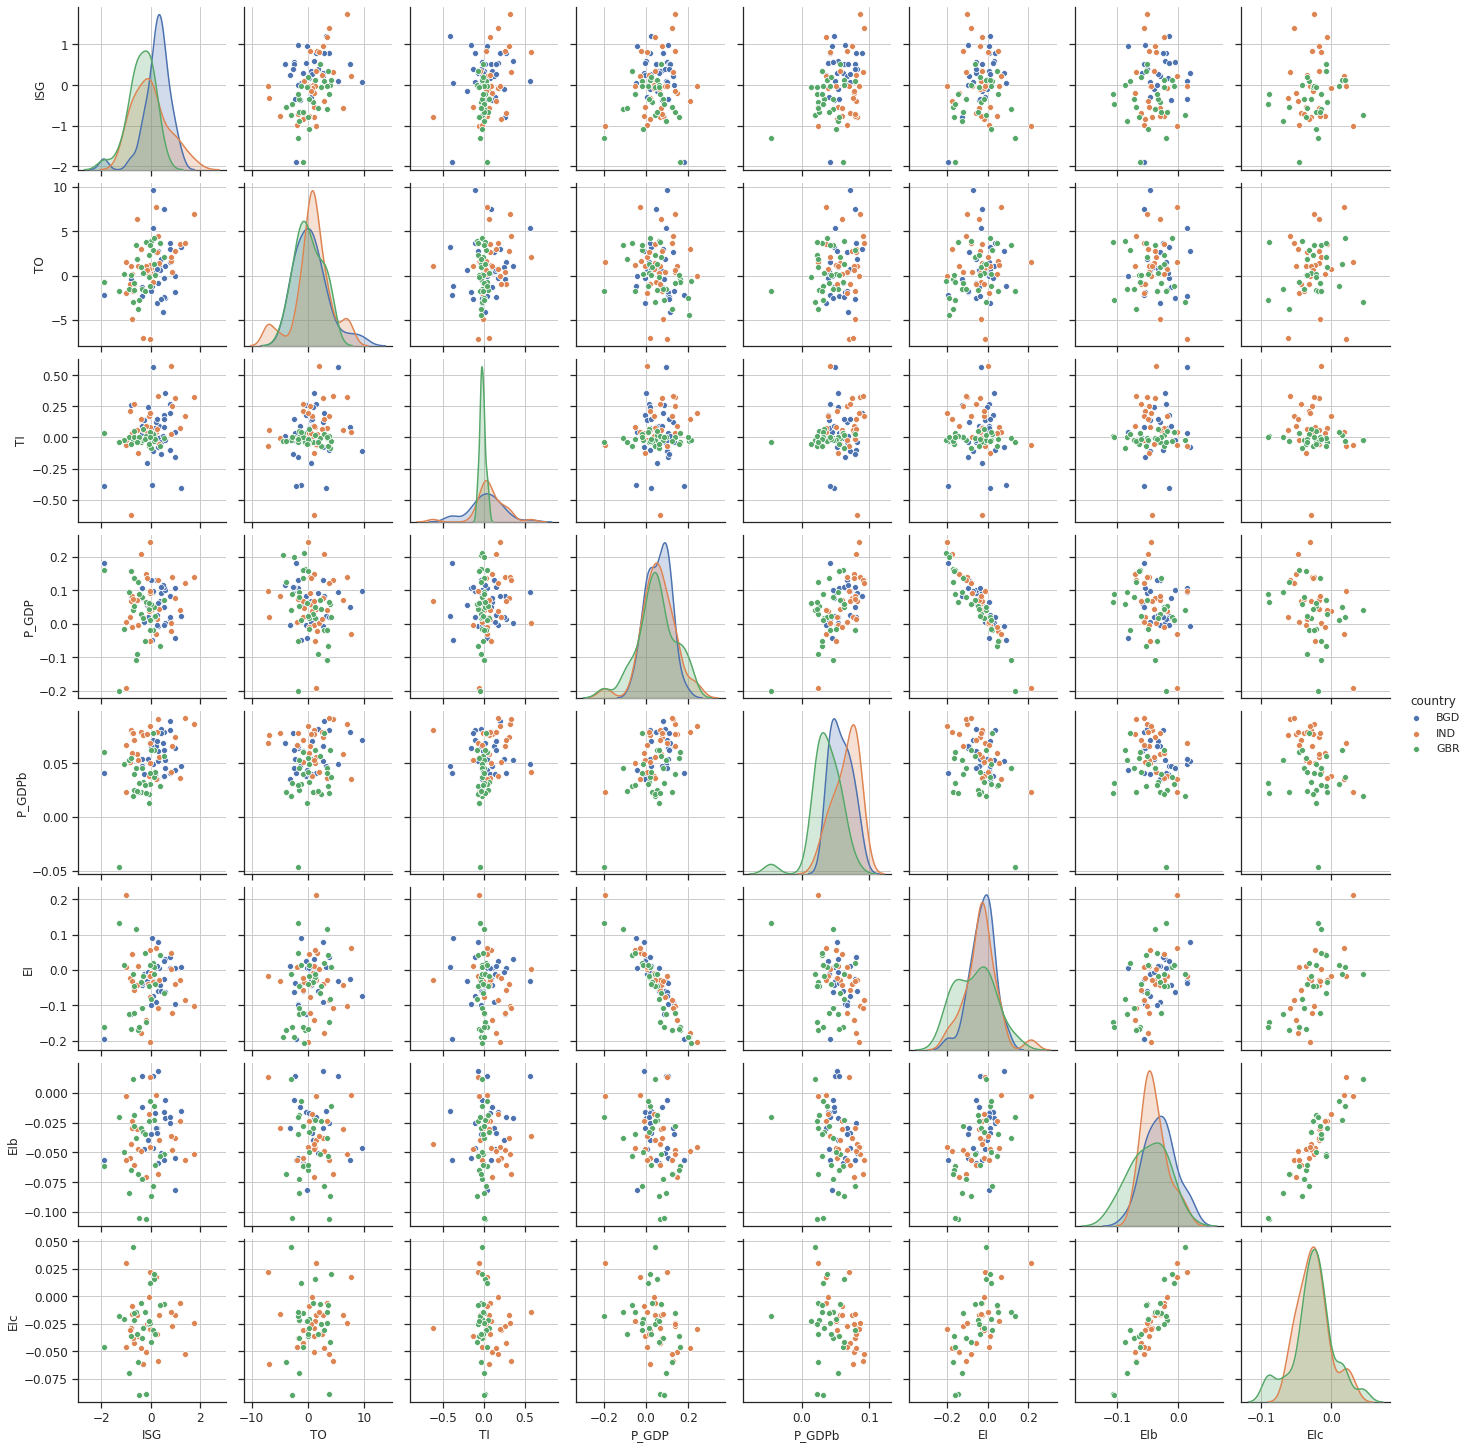

In [24]:
to_compare = logdiff_data.loc[pd.IndexSlice[['GBR','IND', 'BGD'],:], :].reset_index().drop(columns='year')
g = sns.pairplot(to_compare, hue='country')
g.fig.subplots_adjust(left=0.075)
save_fig('logdiff_pairplot.pdf')

In [25]:
by_country_var = logdiff_data.stack().groupby(level=[0,2])
jb = by_country_var.apply(lambda x: stats.jarque_bera(x)[1]).unstack()
display(np.round(jb, 3))
print(jb.reset_index().to_latex(float_format=f3n, index=False))

,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
BGD,0.355,0.892,NaN,0.000,0.748,0.413,0.786,0.016
GBR,0.577,0.713,0.805,0.131,0.706,0.000,0.777,0.531
IND,0.077,0.299,0.396,0.313,0.079,0.337,0.000,0.305


\begin{tabular}{lrrrrrrrr}
\toprule
country &    EI &   EIb &   EIc &   ISG &  P\_GDP &  P\_GDPb &    TI &    TO \\
\midrule
    BGD & 0.355 & 0.892 &       &     * &  0.748 &   0.413 & 0.786 & 0.016 \\
    GBR & 0.577 & 0.713 & 0.805 & 0.131 &  0.706 &       * & 0.777 & 0.531 \\
    IND & 0.077 & 0.299 & 0.396 & 0.313 &  0.079 &   0.337 &     * & 0.305 \\
\bottomrule
\end{tabular}



In [26]:
logdiffstacked = logdiff_data.stack().reset_index()
logdiffstacked.columns = ['country', 'year', 'variable', 'value']
foo = 4

In [27]:
logdiff_data.xs('BGD', level='country').head()

,ISG,TO,TI,P_GDP,P_GDPb,EI,EIb,EIc
year,,,,,,,,
1986,0.057351,-1.203442,-0.380055,-0.049250,NaN,0.091232,NaN,NaN
1987,-0.778197,-0.330945,0.263191,0.083375,NaN,-0.125358,NaN,NaN
1988,0.335391,0.990267,0.094559,0.063776,NaN,0.004645,NaN,NaN
1989,-0.149502,0.647110,-0.208218,0.054385,NaN,-0.031072,NaN,NaN
1990,0.358919,0.641328,0.000000,0.069068,NaN,-0.042025,NaN,NaN


In [28]:
%get data_dir --from em-2020
%get log_cols --from em-2020
suppressMessages({
library(data.table)
library(dplyr)
library(tseries)
})
data.raw <- read.csv(file.path(data_dir, 'WB_IND_current.csv'))


data.log <- copy(data.raw)
data.log[log_cols] <- log(data.raw[log_cols])

# data.logdiff <- diff(as.matrix(log(data.raw)))
data.logdiff <- cbind(data.raw[-1,'year', drop=FALSE], diff(as.matrix(subset(data.log, select=-year))))

data <- subset(data.raw, year >= 1986)
data.log <- subset(data.log, year >= 1986)
data.logdiff <- subset(data.logdiff, year >= 1986)


In [29]:
logdiff_data.stack().groupby(level=[0,2]).min().unstack()

,ISG,TO,TI,P_GDP,P_GDPb,EI,EIb,EIc
country,,,,,,,,
BGD,-1.896908,-4.131700,-0.408576,-0.049250,0.035108,-0.196223,-0.081929,NaN
IND,-1.011975,-7.095351,-0.618082,-0.192961,0.023374,-0.202806,-0.070401,-0.06157
GBR,-1.903477,-4.389468,-0.083535,-0.200056,-0.046244,-0.206272,-0.105722,-0.08975


In [30]:
apply(subset(data.logdiff, select=-year), 2, min, na.rm=1)

ISG          TO       P_GDP      P_GDPb          EI         EIb 
-1.01197532 -7.09535080 -0.19296104  0.02337388 -0.20280615 -0.07040085 
         TI         EIc 
-0.61808239 -0.06157006

In [31]:
apply(subset(data.logdiff, select=-year), 2, function(x) { jarque.bera.test(na.omit(x)) })

$ISG

	Jarque Bera Test

data:  na.omit(x)
X-squared = 2.3226, df = 2, p-value = 0.3131


$TO

	Jarque Bera Test

data:  na.omit(x)
X-squared = 2.3746, df = 2, p-value = 0.305


$P_GDP

	Jarque Bera Test

data:  na.omit(x)
X-squared = 5.0684, df = 2, p-value = 0.07932


$P_GDPb

	Jarque Bera Test

data:  na.omit(x)
X-squared = 2.176, df = 2, p-value = 0.3369


$EI

	Jarque Bera Test

data:  na.omit(x)
X-squared = 5.1323, df = 2, p-value = 0.07683


$EIb

	Jarque Bera Test

data:  na.omit(x)
X-squared = 2.415, df = 2, p-value = 0.2989


$TI

	Jarque Bera Test

data:  na.omit(x)
X-squared = 30.767, df = 2, p-value = 2.085e-07


$EIc

	Jarque Bera Test

data:  na.omit(x)
X-squared = 1.8524, df = 2, p-value = 0.3961



In [32]:
jb.loc[['IND']]

,EI,EIb,EIc,ISG,P_GDP,P_GDPb,TI,TO
country,,,,,,,,
IND,0.076829,0.298947,0.396053,0.313074,0.079324,0.336882,2.085119e-07,0.30504
